In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import Tensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import itertools
from tqdm import tqdm
import seaborn as sns

import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import snntorch.functional as SF
import snntorch.spikeplot as splt

from toolbox import and_generator, or_generator, xor_generator, forward_pass, set_seed

sns.set(style="darkgrid")


batch_size = 32
beta = 0.9
threshold = 0.9
surrogate_gradient = surrogate.fast_sigmoid()
adam_betas = (0.9, 0.999)
rates = (0.9, 0.1)
epochs = 30
timesteps = 10
seed = 1
learning_rate = 1e-1
seed = 3

def predict(x, y, model, timesteps):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    spk, _ = forward_pass(model, torch.tensor([x, y], dtype=torch.float32).to(device), timesteps)
    _, idx = spk[:, None, :].sum(dim=0).max(1)
    return idx

def get_decision_surface(model, timesteps):
    xdata = np.linspace(0, 1, 10)
    ydata = np.linspace(0, 1, 10)
    X, Y, Z = [], [], []
    for x, y in np.array(list(itertools.product(xdata, ydata))):
        X.append(x)
        Y.append(y)
        Z.append(predict(x, y, model, timesteps).item())

    X = np.array(X).reshape(10, 10)
    Y = np.array(Y).reshape(10, 10)
    Z = np.array(Z).reshape(10, 10)
    return Z

def plot_decision_surface(decision_surface):
    xdata = np.linspace(0, 1, 10)
    ydata = np.linspace(0, 1, 10)
    X, Y = [], []
    for x, y in np.array(list(itertools.product(xdata, ydata))):
        X.append(x)
        Y.append(y)
    X = np.array(X).reshape(10, 10)
    Y = np.array(Y).reshape(10, 10)
    plt.contourf(X, Y, decision_surface, cmap='plasma')
    plt.title("Decision surface", y=1.05)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

def forward_pass(net, data, num_steps):
  spk_rec = []
  mem_hist = []
  utils.reset(net)

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      mem_hist.append(mem_out.cpu().detach().numpy())
      spk_rec.append(spk_out)

  return torch.stack(spk_rec), np.stack(mem_hist)

def train(
    batch_size = batch_size,
    beta = beta,
    threshold = threshold,
    adam_betas = adam_betas,
    rates = rates,
    epochs = epochs,
    timesteps = timesteps,
    learning_rate = learning_rate,
    seed = seed
):
    set_seed(seed=seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loader = DataLoader(and_generator(size=700), 32)
    test_loader = DataLoader(and_generator(size=300), 32)

    net = nn.Sequential(
        nn.Linear(2, 8),
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate_gradient, init_hidden=True),
        nn.Linear(8, 2),
        snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate_gradient, init_hidden=True, output=True)
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=adam_betas)
    correct_rate, incorrect_rate = rates
    loss_fn = SF.mse_count_loss(correct_rate=correct_rate, incorrect_rate=incorrect_rate)

    surface_history = []
    train_loss_history = []
    test_loss_history = []
    for epoch in tqdm(range(epochs)):
        with torch.no_grad():
            decision_surface = get_decision_surface(net, timesteps)
            surface_history.append(decision_surface)

        train_epoch_loss_val = 0
        for i, (data, targets) in enumerate(iter(train_loader)):
            data = data.to(device)
            targets = targets.squeeze().to(device)

            net.train()
            spk_rec, mem_hist = forward_pass(net, data, timesteps) # forward-pass
            loss_val = loss_fn(spk_rec, targets) # loss calculation
            optimizer.zero_grad() # null gradients
            loss_val.backward() # calculate gradients
            optimizer.step() # update weights
            train_epoch_loss_val += loss_val.item()
        train_loss_history.append(train_epoch_loss_val/batch_size)


        test_epoch_loss_val = 0
        for i, (data, targets) in enumerate(iter(test_loader)):
            data = data.to(device)
            targets = targets.squeeze().to(device)

            net.eval()
            spk_rec, mem_hist = forward_pass(net, data, timesteps)
            loss_val = loss_fn(spk_rec, targets)
            test_epoch_loss_val += loss_val.item()
        test_loss_history.append(loss_val.item()/batch_size)
    return surface_history, train_loss_history, test_loss_history

### Random seeds correlation

Random seed set as 1
Random seed set as 2
Random seed set as 3
Random seed set as 4
Random seed set as 5
Random seed set as 6
Random seed set as 7
Random seed set as 8
Random seed set as 9
Average corr 0.09889590184001511


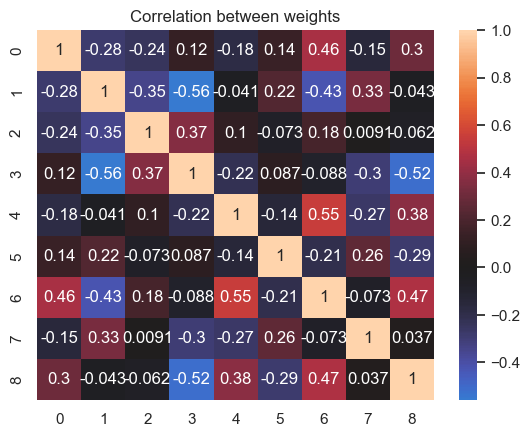

In [2]:
import torch.nn.init as init
import torch
import math

seqs = []
for seed in np.arange(1, 10, 1):
    set_seed(seed)
    weights = torch.empty(2, 8)
    init.kaiming_uniform_(weights, a=math.sqrt(5))
    seqs.append(weights.flatten())
sns.heatmap(np.corrcoef(np.vstack(seqs)), center=0, annot=True)
plt.title("Correlation between weights")
print("Average corr", np.mean(np.corrcoef(np.vstack(seqs))))

Random seed set as 1
Random seed set as 19
Random seed set as 4031
Random seed set as 90
Random seed set as 112
Random seed set as 373
Random seed set as 976
Random seed set as 9222
Random seed set as 17301
Average corr 0.14323087542813798


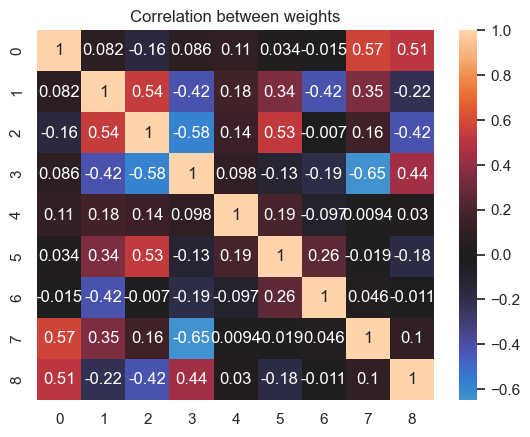

In [3]:
seqs = []
for seed in [1, 19, 4031, 90, 112, 373, 976, 9222, 17301]:
    set_seed(seed)
    weights = torch.empty(2, 8)
    init.kaiming_uniform_(weights, a=math.sqrt(5))
    seqs.append(weights.flatten())
sns.heatmap(np.corrcoef(np.vstack(seqs)), center=0, annot=True)
plt.title("Correlation between weights")
print("Average corr", np.mean(np.corrcoef(np.vstack(seqs))))

There doesn't seem to be any abnormal correlation between weights generated on subsequent seeds when compared to arbitraly random seeds.

In [4]:
import pickle

seeds = np.arange(1, 20, 1)

filename = "seeds_dict2.pkl"
if os.path.exists(filename):
    with open(filename, "rb") as f:
        seeds_dict = pickle.load(f)
    print("Loaded", filename)
else:
    seeds_dict = {}
    for seed in tqdm(seeds):
        seeds_dict[seed] = train(seed=seed)
    with open(filename, "wb") as f:
        pickle.dump(seeds_dict, f)

  0%|          | 0/19 [00:00<?, ?it/s]

Random seed set as 1


  5%|▌         | 1/19 [00:29<08:48, 29.36s/it]

Random seed set as 2


 11%|█         | 2/19 [00:58<08:13, 29.05s/it]

Random seed set as 3


 16%|█▌        | 3/19 [01:27<07:44, 29.03s/it]

Random seed set as 4


 21%|██        | 4/19 [01:56<07:18, 29.23s/it]

Random seed set as 5


 26%|██▋       | 5/19 [02:25<06:48, 29.15s/it]

Random seed set as 6


 32%|███▏      | 6/19 [02:54<06:18, 29.15s/it]

Random seed set as 7


 37%|███▋      | 7/19 [03:24<05:51, 29.25s/it]

Random seed set as 8


 42%|████▏     | 8/19 [03:54<05:24, 29.50s/it]

Random seed set as 9


 47%|████▋     | 9/19 [04:24<04:56, 29.62s/it]

Random seed set as 10


 53%|█████▎    | 10/19 [04:54<04:27, 29.70s/it]

Random seed set as 11


 58%|█████▊    | 11/19 [05:24<03:59, 29.91s/it]

Random seed set as 12


 63%|██████▎   | 12/19 [05:54<03:29, 29.94s/it]

Random seed set as 13


 68%|██████▊   | 13/19 [06:24<02:59, 29.96s/it]

Random seed set as 14


 74%|███████▎  | 14/19 [06:54<02:29, 29.97s/it]

Random seed set as 15


 79%|███████▉  | 15/19 [07:24<02:00, 30.05s/it]

Random seed set as 16


 84%|████████▍ | 16/19 [07:54<01:30, 30.03s/it]

Random seed set as 17


 89%|████████▉ | 17/19 [08:25<01:00, 30.25s/it]

Random seed set as 18


 95%|█████████▍| 18/19 [08:55<00:30, 30.19s/it]

Random seed set as 19


100%|██████████| 19/19 [09:25<00:00, 29.77s/it]


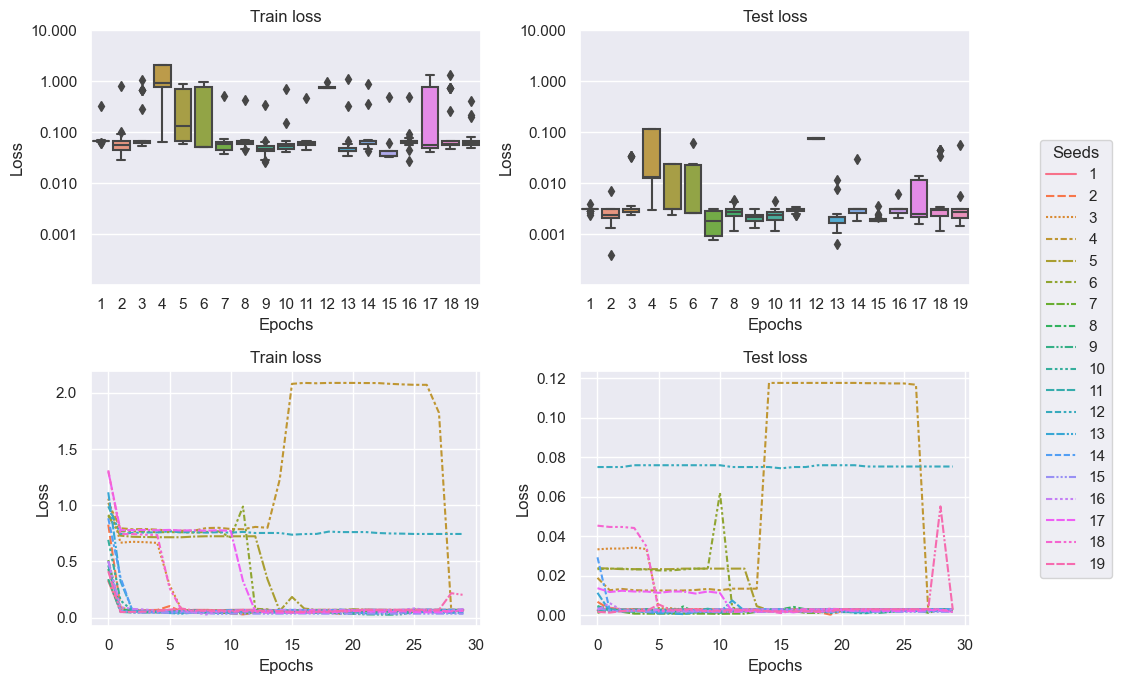

In [5]:
import matplotlib.ticker as ticker

all_train_loss = [seeds_dict[seed][1] for seed in seeds_dict]
all_test_loss = [seeds_dict[seed][2] for seed in seeds_dict]

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()

ax0 = sns.boxplot(all_train_loss, ax=ax[0])
ax0.set(xlabel="Epochs", ylabel="Loss", title="Train loss", xticklabels=seeds)
ax1 = sns.boxplot(all_test_loss, ax=ax[1])
ax1.set(xlabel="Epochs", ylabel="Loss", title="Test loss", xticklabels=seeds)
ax2 = sns.lineplot(all_train_loss, ax=ax[2], legend=False)
ax2.set(xlabel="Epochs", ylabel="Loss", title="Train loss")
ax3 = sns.lineplot(all_test_loss, ax=ax[3], legend=True)
ax3.set(xlabel="Epochs", ylabel="Loss", title="Test loss")

handles, labels = ax3.get_legend_handles_labels()
ax3.get_legend().remove()
fig.legend(handles, np.arange(1, 20, 1), loc='upper left', ncol=1, bbox_to_anchor=(1.04, 0.8), title="Seeds")


formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
for axis in [ax0, ax1]:
    axis.set_yscale('log')
    axis.set_yticks([0.001, 0.01, 0.1, 1, 10])
    axis.yaxis.set_major_formatter(formatter)
    axis.set_ylim([0.0001, 10])
    axis.set_xticks = seeds

plt.tight_layout()
plt.show()

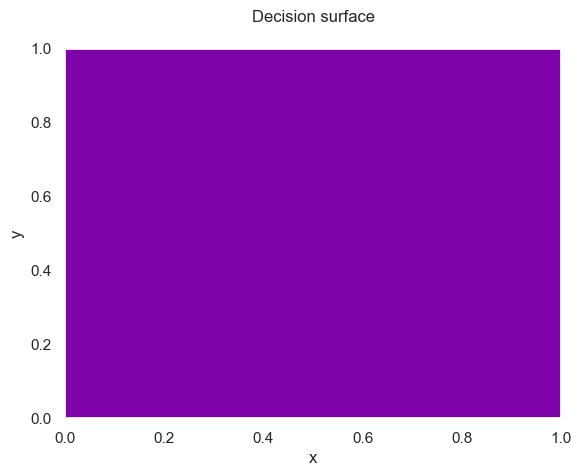

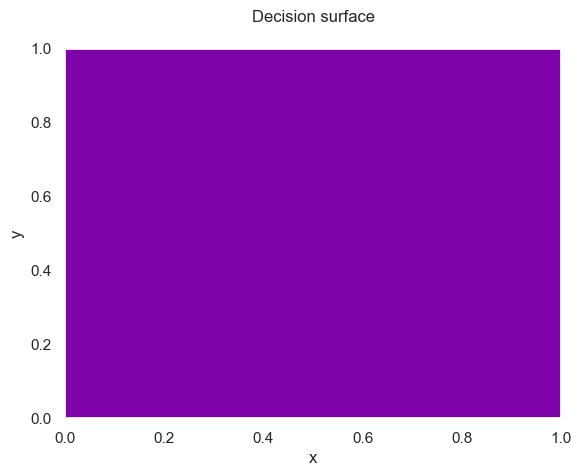

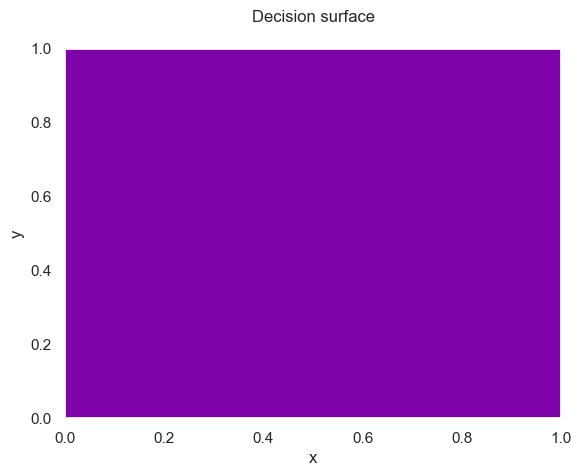

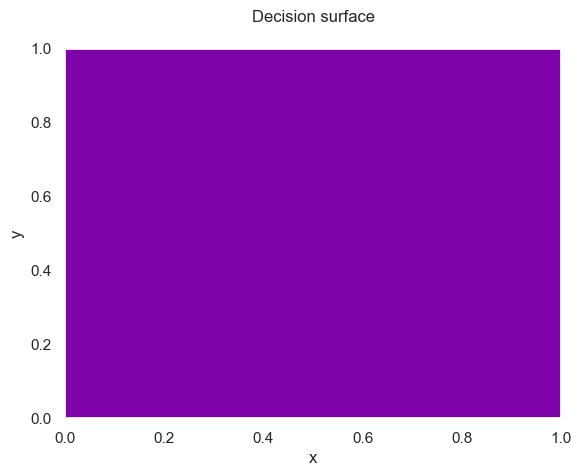

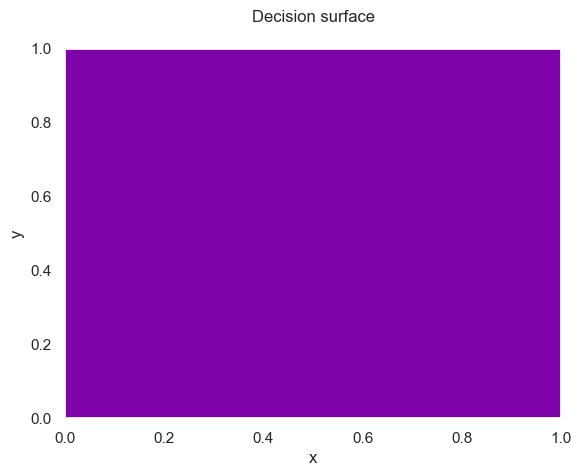

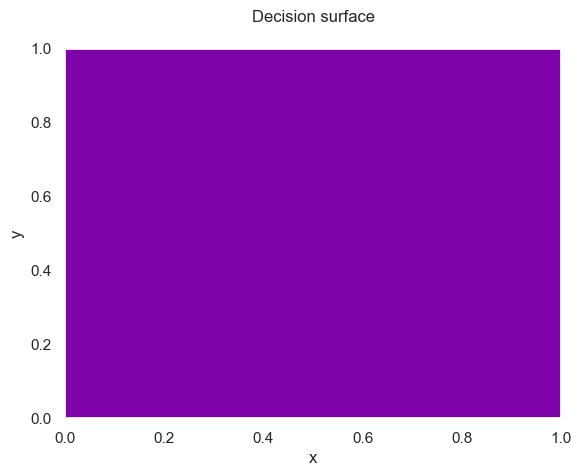

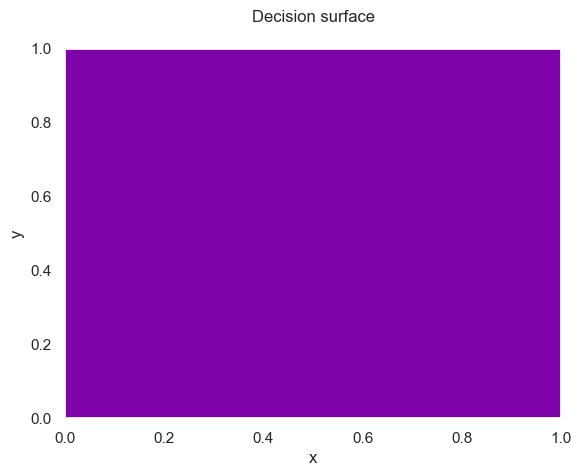

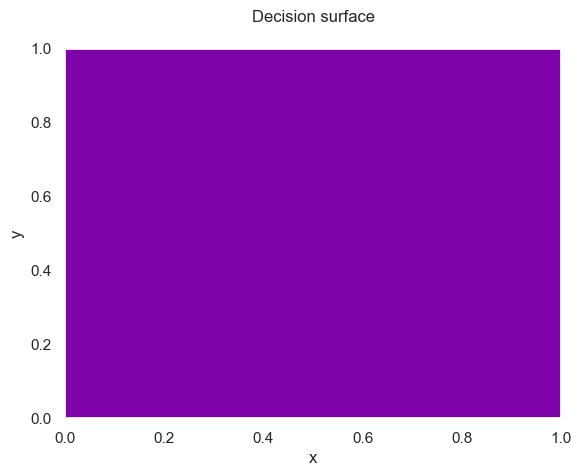

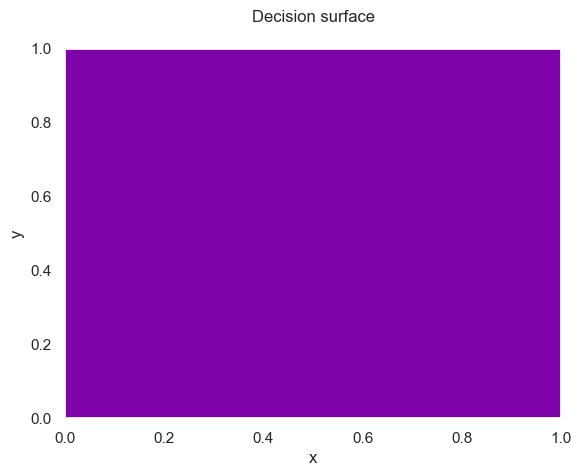

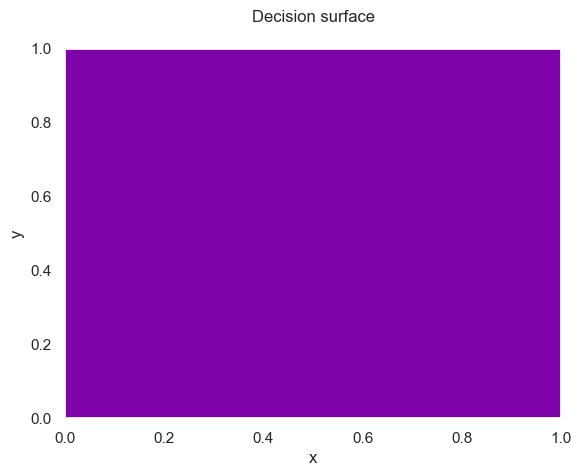

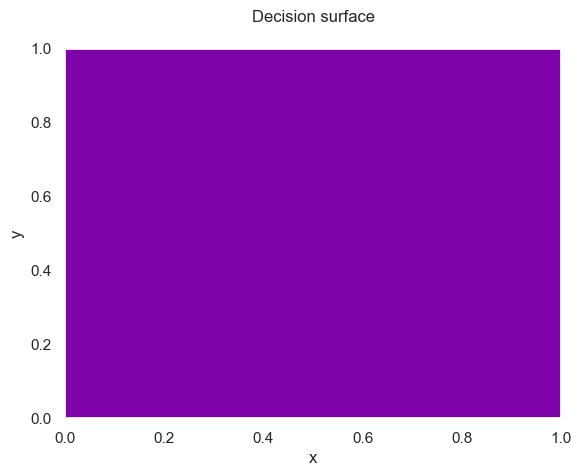

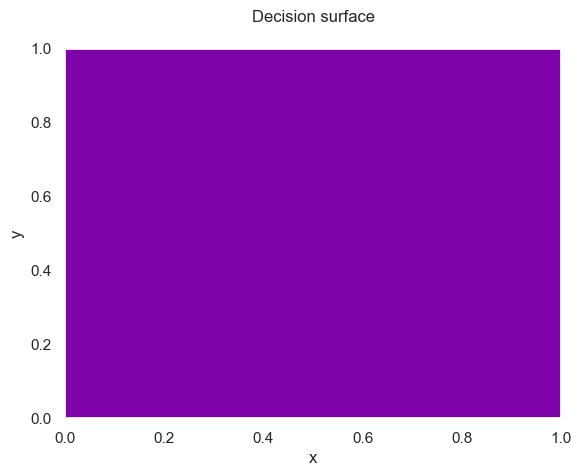

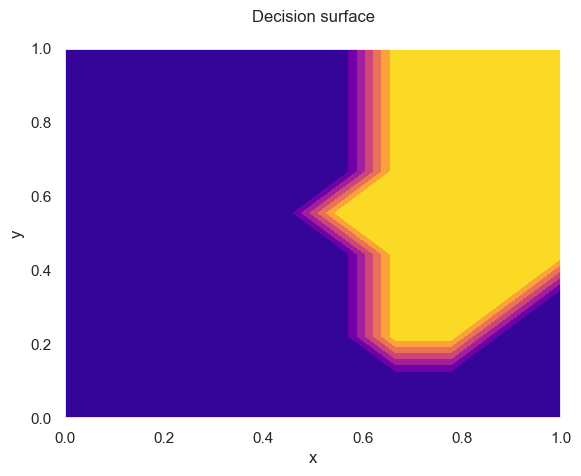

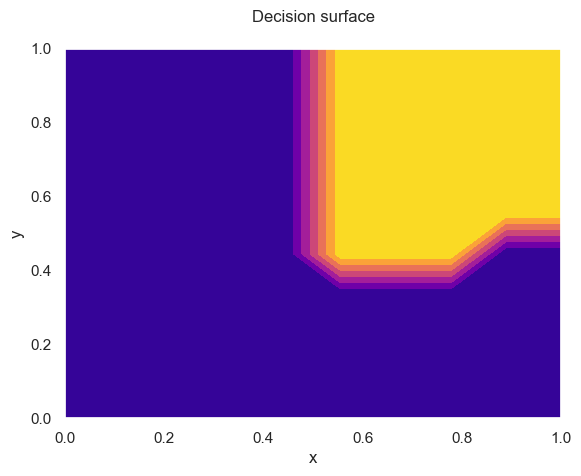

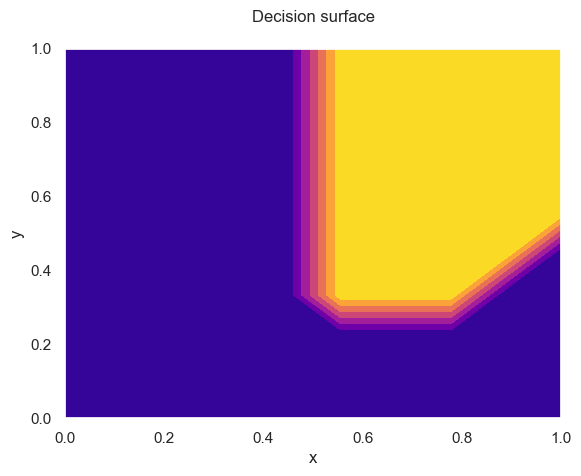

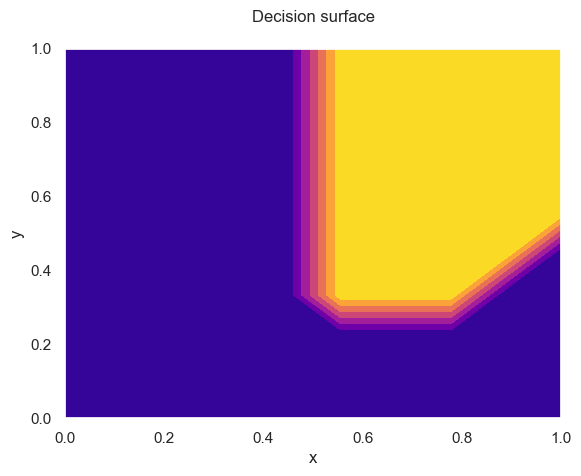

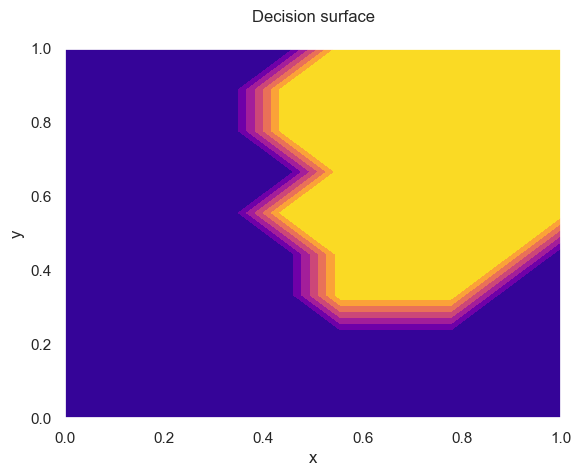

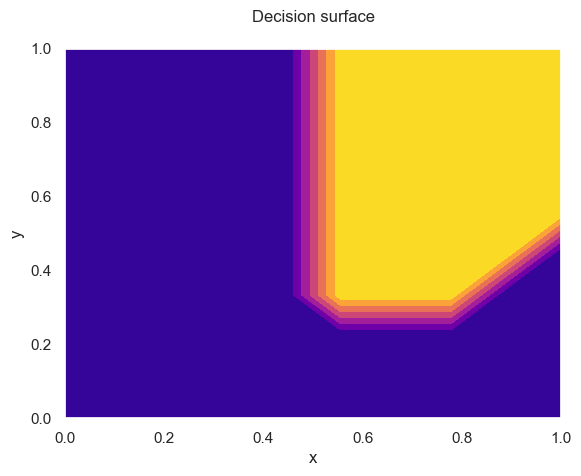

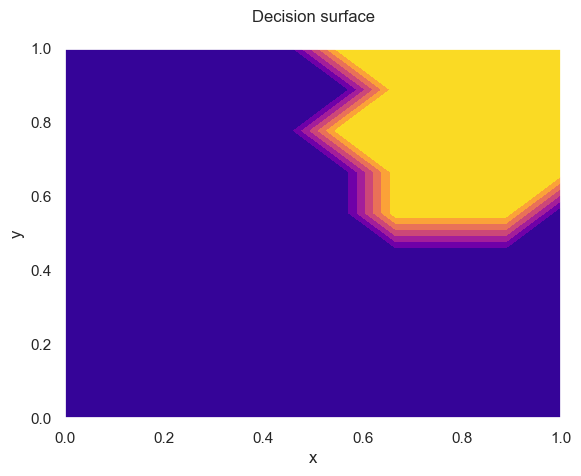

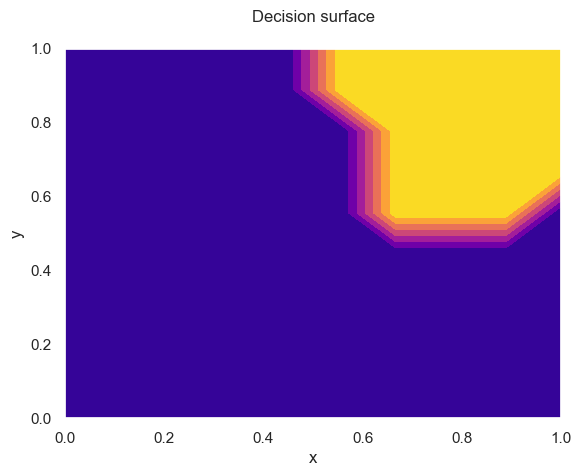

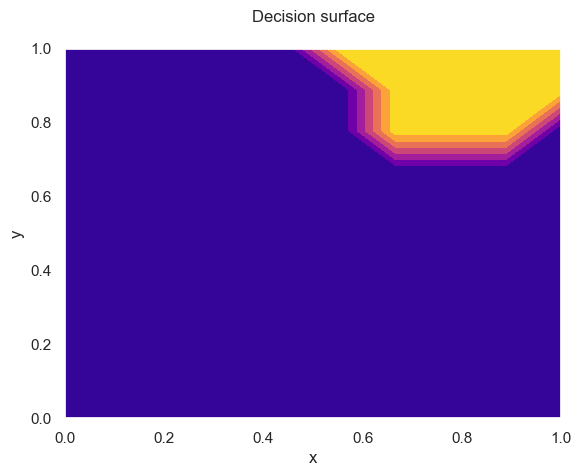

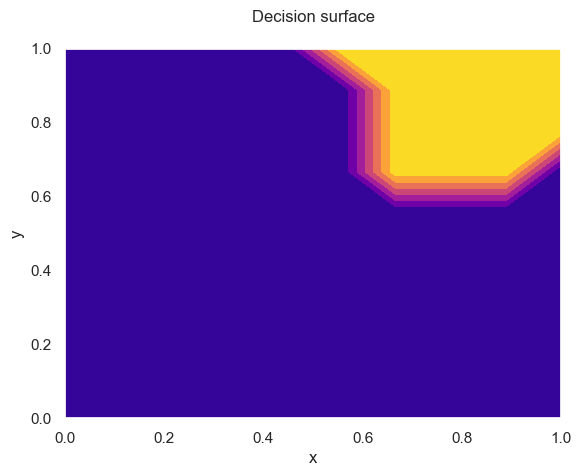

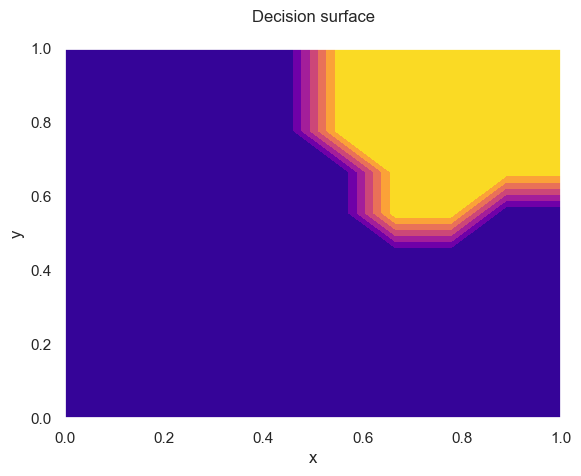

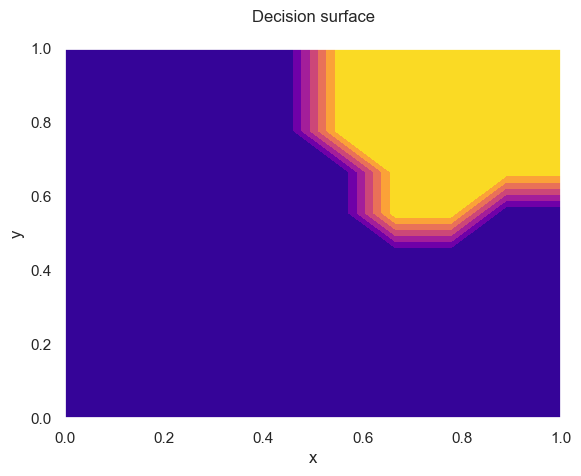

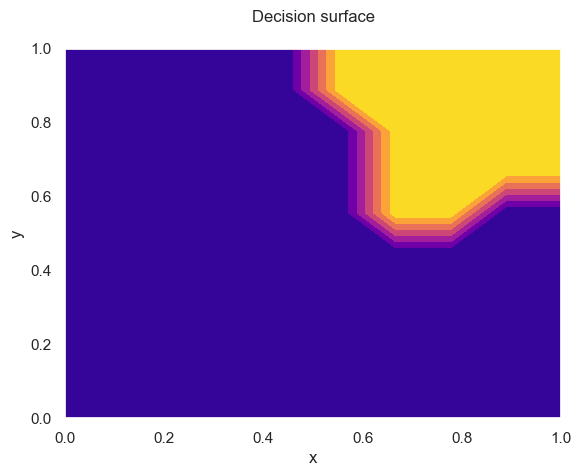

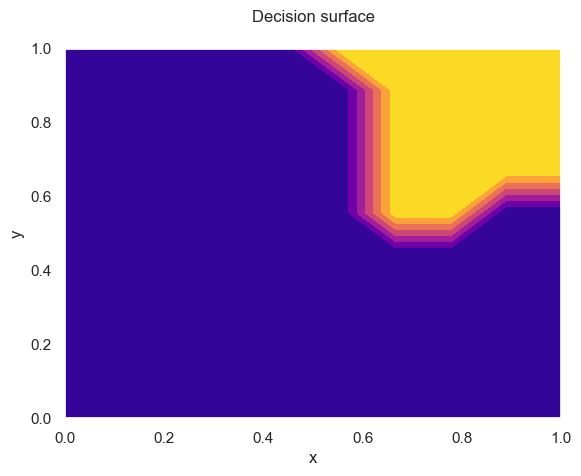

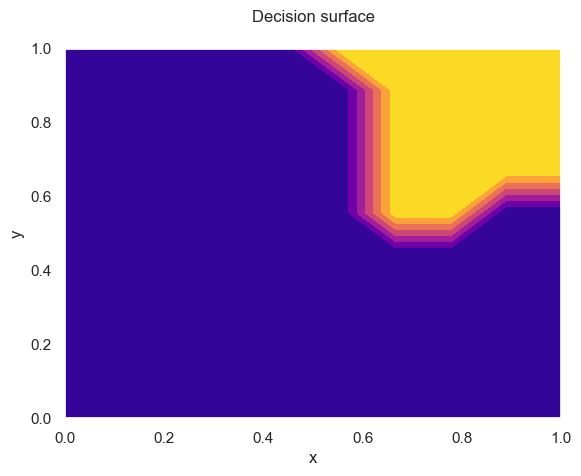

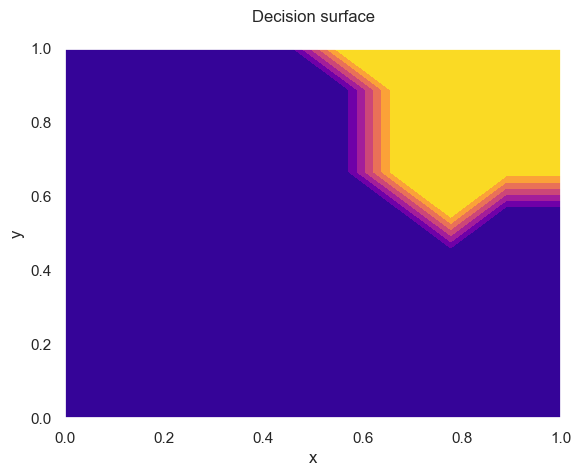

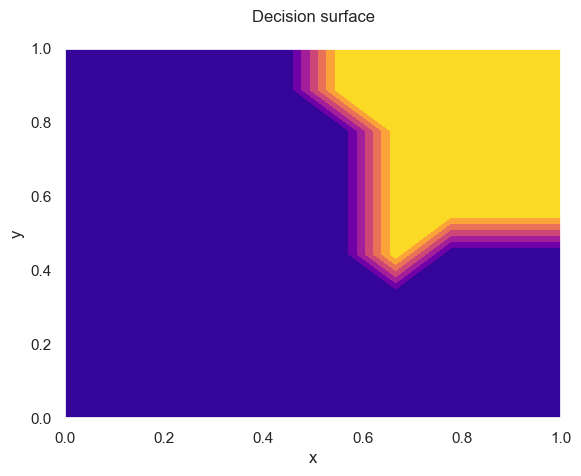

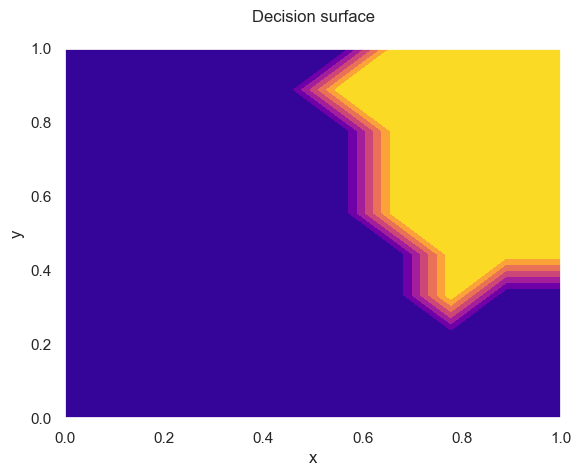

In [7]:
for z in seeds_dict[17][0]:
    plot_decision_surface(z)